In [5]:
import scipy.io as sio
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

### Pacejka Magic Formula

In [6]:
# def fit(data, b0, b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13):
#     FZ = data[0]
#     SR = data[1]

#     C = b0
#     D = FZ * (b1 * FZ + b2)
    
#     BCD = (b3 * FZ**2 + b4 * FZ) * np.exp(-1 * b5 * FZ)
#     B = BCD / (C * D)
#     H = b9 * FZ + b10

#     E = (b6 * FZ**2 + b7 * FZ + b8) * (1 - b13 * np.sign(SR + H))

#     V = b11 * FZ + b12
#     Bx1 = B * (SR + H)

#     return D * np.sin(C * np.arctan(Bx1 - E * (Bx1 - np.arctan(Bx1)))) + V

# B = 0.171
# C = 1.69
# D = 4236
# E = 0.619

def fit(data, B, C, D, E):
    FZ = data[0]
    SR = data[1]

    return D * np.sin(C * np.arctan(B * SR - E * (B * SR - np.arctan(B * SR))))

### Desired Parameters for Filtering

In [7]:
tires = {"hoosier_r25b_18x7-5_10x8":{"long":None, "lat":None}}

camber = 0 # default camber
pressure = 12 * 6.89476 # default pressure
velocity = 25 * 1.60934 # default velocity
slip_angle = 0
run_num = 1


### Import and Filter Tire Data

In [8]:
for name, tire in tires.items():
    try:
        df = pd.read_csv(f"../tire_data/processed_data/braking_{name}.csv")
        tire["long"] = df[(df["pressure"] == pressure) & (df["velocity"] == velocity) & (df["camber"] == camber)]
        # print(tire["long"])
        
    except:
        print("Error getting long data for {0}".format(name))

    try:
        df = pd.read_csv(f"../tire_data/processed_data/cornering_{name}.csv")
        tire["lat"] = df[(df["velocity"] == velocity) & (df["pressure"] == pressure)]
        # print(tire["lat"])

    except:
        print("Error getting lateral data for {0}".format(name))

### Pacejka Fit Solver

In [9]:
df = tires["hoosier_r25b_18x7-5_10x8"]["long"]

x_lst = df["FZ"].tolist()
y_lst = df["SR"].tolist()

z_lst = df["FX"].tolist()

# a_vals = [1.5, 0, 1100, 0, 300, 0, 0, 0, -2, 0, 0, 0, 0, 0]

# parameters, covariance = curve_fit(fit, [x_lst, y_lst], z_lst, a_vals, maxfev = 10000)

a_vals = [0.171, 1.69, 4236, 0.619]

parameters, covariance = curve_fit(fit, [x_lst, y_lst], z_lst, a_vals, maxfev = 10000)

print("Coefficients:", parameters)


Coefficients: [7.42770144e-01 1.73763800e+01 2.01450576e+03 6.02800498e+01]


### Plotting

In [10]:
z_fitted = []
for i in range(len(x_lst)):
    z_fitted.append(fit([x_lst[i], y_lst[i]], *parameters))

model_x_data = np.linspace(min(x_lst), max(x_lst), 30)
model_y_data = np.linspace(min(y_lst), max(y_lst), 30)
model_z_data = np.linspace(min(z_fitted), max(z_fitted), 30)

X, Y, Z = np.meshgrid(model_x_data, model_y_data, model_z_data)

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)

ax.plot_surface(X, Y, Z)

ax.set_xlabel('Normal Load (N)')
ax.set_ylabel('Slip Angle (deg)')
ax.set_zlabel('Long Force (N)')

plt.show()

ValueError: Argument Z must be 2-dimensional.

<Figure size 640x480 with 0 Axes>

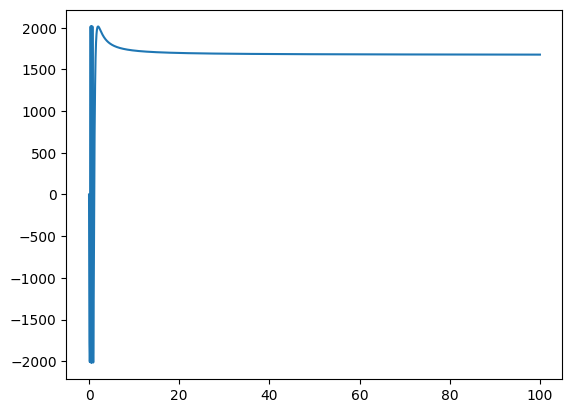

In [12]:
params = parameters.tolist()

SR = np.arange(0, 100, 0.001)

FX = fit([-250 / 0.224809, SR], *params) * -1

plt.plot(SR, FX)

plt.show()

In [107]:
ia_count = 0

for i in range(len(x_lst)):
    predicted = fit([x_lst[i], y_lst[i]], *parameters)

    # print(predicted, z_lst[i])

    error = (z_lst[i] - predicted) / predicted * 100

    if error >= 10:
        ia_count += 1

print("Accuracy: " + str((1 - ia_count / len(x_lst)) * 100) + "%")

Accuracy: 59.05252317198764%


C:\Users\rober\AppData\Local\Temp\ipykernel_29244\2810511625.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  error = (z_lst[i] - predicted) / predicted * 100
